In [164]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
import xgboost as xgb

delivery_data = pl.read_csv('/Users/ryanquach/Downloads/deliverytime.csv')

In [165]:
delivery_data.head()

ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
str,str,i64,f64,f64,f64,f64,f64,str,str,i64
"""4607""","""INDORES13DEL02…",37,4.9,22.745049,75.892471,22.765049,75.912471,"""Snack ""","""motorcycle """,24
"""B379""","""BANGRES18DEL02…",34,4.5,12.913041,77.683237,13.043041,77.813237,"""Snack ""","""scooter """,33
"""5D6D""","""BANGRES19DEL01…",23,4.4,12.914264,77.6784,12.924264,77.6884,"""Drinks ""","""motorcycle """,26
"""7A6A""","""COIMBRES13DEL0…",38,4.7,11.003669,76.976494,11.053669,77.026494,"""Buffet ""","""motorcycle """,21
"""70A2""","""CHENRES12DEL01…",32,4.6,12.972793,80.249982,13.012793,80.289982,"""Snack ""","""scooter """,30


In [166]:
delivery_data.describe()

describe,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
str,str,str,f64,f64,f64,f64,f64,f64,str,str,f64
"""count""","""45593""","""45593""",45593.0,45593.0,45593.0,45593.0,45593.0,45593.0,"""45593""","""45593""",45593.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",null,null,29.544075,4.632367,17.017729,70.231332,17.465186,70.845702,null,null,26.294607
"""std""",null,null,5.696793,0.327708,8.185109,22.883647,7.335122,21.118812,null,null,9.383806
"""min""","""1.1E+01""","""AGRRES010DEL01…",15.0,1.0,-30.905562,-88.366217,0.01,0.01,"""Buffet ""","""bicycle """,10.0
"""25%""",null,null,25.0,4.6,12.933284,73.17,12.988453,73.28,null,null,19.0
"""50%""",null,null,29.0,4.7,18.546947,75.898497,18.633934,76.002574,null,null,26.0
"""75%""",null,null,34.0,4.8,22.728163,78.044095,22.785049,78.107044,null,null,32.0
"""max""","""FFE""","""VADRES20DEL03""",50.0,6.0,30.914057,88.433452,31.054057,88.563452,"""Snack ""","""scooter """,54.0


## Data Cleaning

In [167]:
def haversine(long_start, lat_start, long_end, lat_end):
    long_start, lat_start, long_end, lat_end = map(np.radians, [long_start, lat_start, long_end, lat_end])
    
    long_dist = long_end - long_start 
    lat_dist = lat_end - lat_start 
    a = np.sin(lat_dist/2) ** 2 + np.cos(lat_start) * np.cos(lat_end) * np.sin(long_dist/2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

delivery_data = (delivery_data
                .select(pl.exclude(['ID', 'Delivery_person_ID']))
                .with_columns(pl.col('Type_of_order').str.to_lowercase())
                .select(pl.all().name.map(lambda col_name: col_name.lower()))
                .rename({'restaurant_latitude': 'orig_lat',
                         'restaurant_longitude': 'orig_long',
                         'delivery_location_latitude': 'dest_lat',
                         'delivery_location_longitude': 'dest_long',
                         'time_taken(min)': 'time_taken'})
                .with_columns(haversine(pl.col('orig_lat'), pl.col('orig_long'), 
                                        pl.col('dest_lat'), pl.col('dest_long')).alias('distance').round(2))
                .with_columns([pl.col('type_of_order').str.strip_chars(),
                               pl.col('type_of_vehicle').str.strip_chars()])
                .select(pl.exclude(['orig_lat', 'orig_long', 'dest_lat', 'dest_long']))
                .select(pl.exclude('time_taken'), pl.col('time_taken'))
                )

In [168]:
delivery_data.head()

delivery_person_age,delivery_person_ratings,type_of_order,type_of_vehicle,distance,time_taken
i64,f64,str,str,f64,i64
37,4.9,"""snack""","""motorcycle""",2.29,24
34,4.5,"""snack""","""scooter""",14.78,33
23,4.4,"""drinks""","""motorcycle""",1.14,26
38,4.7,"""buffet""","""motorcycle""",5.7,21
32,4.6,"""snack""","""scooter""",4.51,30


## Data Visualization

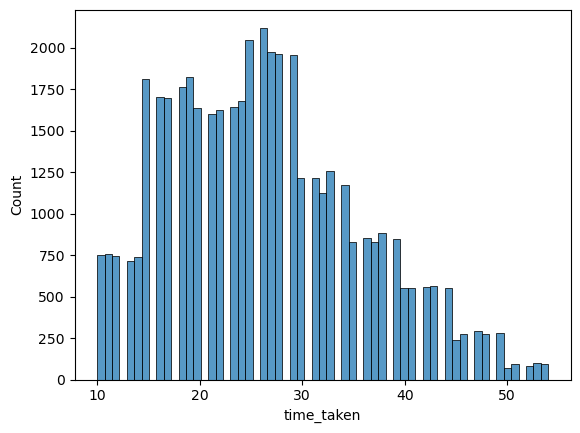

In [182]:
sns.histplot(data = delivery_data, x = 'time_taken');

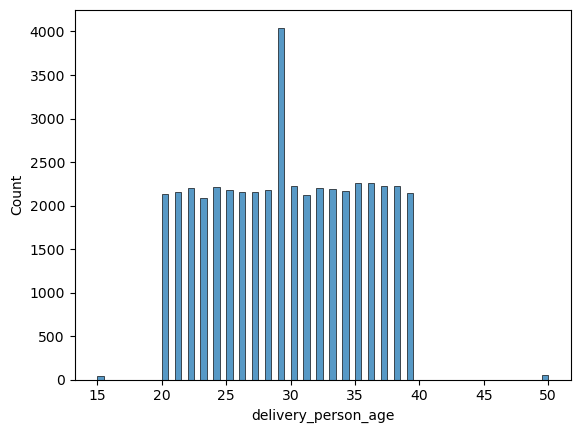

In [183]:
sns.histplot(data = delivery_data, x = 'delivery_person_age');

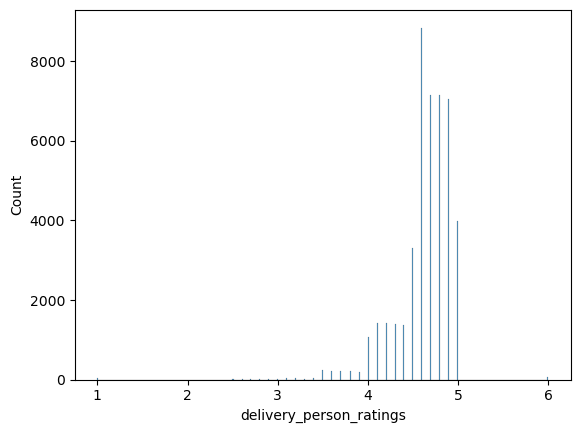

In [184]:
sns.histplot(data = delivery_data, x = 'delivery_person_ratings');

## Preparing Data for ML Process

In [172]:
data_matrix = delivery_data.to_dummies(pl.selectors.string(), drop_first = True)

In [173]:
data_matrix.head(n = 10)

delivery_person_age,delivery_person_ratings,type_of_order_buffet,type_of_order_drinks,type_of_order_meal,type_of_vehicle_bicycle,type_of_vehicle_electric_scooter,type_of_vehicle_scooter,distance,time_taken
i64,f64,u8,u8,u8,u8,u8,u8,f64,i64
37,4.9,0,0,0,0,0,0,2.29,24
34,4.5,0,0,0,0,0,1,14.78,33
23,4.4,0,1,0,0,0,0,1.14,26
38,4.7,1,0,0,0,0,0,5.7,21
32,4.6,0,0,0,0,0,1,4.51,30
22,4.8,1,0,0,0,0,0,3.4,26
33,4.7,0,0,1,0,0,1,12.27,40
35,4.6,0,0,1,0,0,0,14.83,32
22,4.8,1,0,0,0,0,0,14.74,34


In [174]:
X = data_matrix.select(pl.exclude('time_taken')).to_numpy()
Y = data_matrix.select(pl.col('time_taken')).to_numpy()

## Checking for Model Assumptions

In [175]:
mod_check = LinearRegression()
mod_check.fit(X, Y)
mod_pred = mod_check.predict(X)
mod_resid = Y - mod_pred
mod_SR = (mod_resid - np.mean(mod_resid))/np.std(mod_resid)

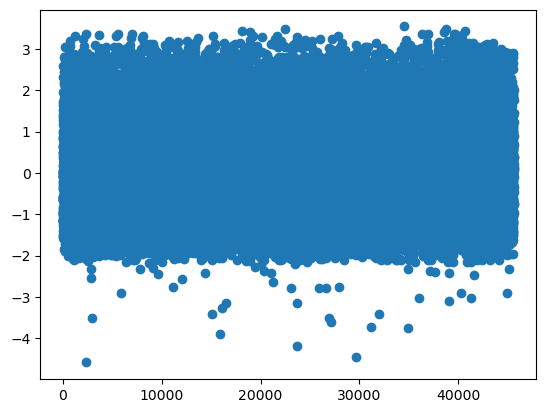

In [185]:
plt.scatter(x = np.arange(1, 45594), y = mod_SR);

In [177]:
print(np.mean(mod_SR))

3.740272773943896e-18


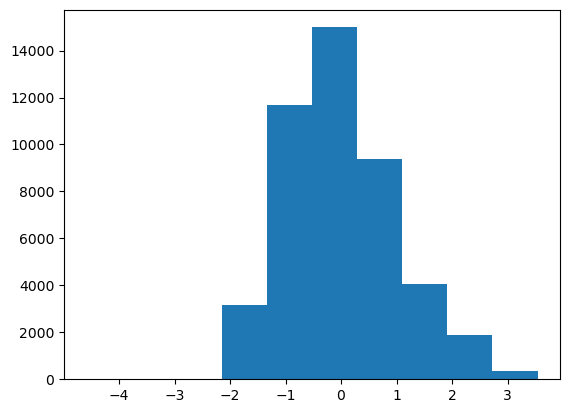

In [186]:
plt.hist(mod_SR);

## Model Creation and Results

In [132]:
mod_lm = LinearRegression()
mod_score = cross_val_score(mod_lm, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-8.33456923, -8.28157107, -8.40964513, -8.27541594, -8.46691408])

In [133]:
mod_lasso = Lasso()
mod_score = cross_val_score(mod_lasso, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-9.00479867, -8.96846343, -8.99101334, -8.8662591 , -9.04264078])

In [134]:
mod_ridge = Ridge()
mod_score = cross_val_score(mod_ridge, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-8.33460888, -8.28165038, -8.40963047, -8.27537094, -8.46681586])

In [135]:
mod_XGB = xgb.XGBRegressor()
mod_score = cross_val_score(mod_XGB, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-7.21896771, -7.21478742, -7.3510929 , -7.30646989, -7.42793913])